# 24HourControl - Search

```
Author: Chia E Tungom
Email: bamtungom@protonmail.com
Date: Aug-02-2022
```

This Notebook demonstrates an approach using an optimization algorithm to find charging and discharge rates at different times of day. This approach can serve as a baseline  for people aiming for a baseline optimization method

__Lets Goooooo!!!__

In [52]:
import numpy as np
import time

from agents.orderenforcingwrapper import OrderEnforcingAgent
from citylearn.citylearn import CityLearnEnv

from citylearn.agents.sac import SAC
from agents import rbc_agent 

In [55]:
# Custom configure enviroment 
class Constants:
    episodes = 3
    schema_path = './data/citylearn_challenge_2022_phase_1/schema.json'

def action_space_to_dict(aspace):
    """ Only for box space """
    return { "high": aspace.high,
             "low": aspace.low,
             "shape": aspace.shape,
             "dtype": str(aspace.dtype)
    }

def env_reset(env):
    observations = env.reset()
    action_space = env.action_space
    observation_space = env.observation_space
    building_info = env.get_building_information()
    building_info = list(building_info.values())
    action_space_dicts = [action_space_to_dict(asp) for asp in action_space]
    observation_space_dicts = [action_space_to_dict(osp) for osp in observation_space]
    obs_dict = {"action_space": action_space_dicts,
                "observation_space": observation_space_dicts,
                "building_info": building_info,
                "observation": observations }
    return obs_dict


In [56]:
# Understand CityLearn Environment

env = CityLearnEnv(schema=Constants.schema_path)


In [57]:
print(f' SAMPLE OBSERVATION SPACE for Builiding ONE >>> {len(env.observation_space[1].sample()), env.observation_space[1].sample()}')


 SAMPLE OBSERVATION SPACE for Builiding ONE >>> (28, array([ 2.7672098e+00,  2.9527459e+00,  5.6035581e+00,  2.4802635e+01,
        1.0635974e+01,  3.2097355e+01,  2.4993612e+01,  3.5267548e+01,
        5.3173855e+01,  7.9673180e+01,  2.0346434e+01,  2.9565106e+02,
        9.0193048e+02,  7.8736237e+02,  8.1491315e+02,  4.7441638e+02,
        2.8167239e+02,  8.9806024e+02,  1.8029411e+01,  8.4368956e-01,
        3.3177731e+00,  2.2103801e+02, -4.5062798e-01,  6.0250189e+02,
        5.5268914e-01, -5.4240066e-01, -1.2251962e-01,  1.7988759e-01],
      dtype=float32))


In [22]:
# There is an action space for every building
print(f' ACTION SPACES {env.action_space}')
print(f' ACTION SPACE for Builiding ONE is {env.action_space[0]}')
env.action_space[1].sample()

 ACTION SPACES [Box(-1.0, 1.0, (1,), float32), Box(-1.0, 1.0, (1,), float32), Box(-1.0, 1.0, (1,), float32), Box(-1.0, 1.0, (1,), float32), Box(-1.0, 1.0, (1,), float32)]
 ACTION SPACE for Builiding ONE is Box(-1.0, 1.0, (1,), float32)


array([-0.9365141], dtype=float32)

In [5]:
import random
Actions = [([random.uniform(-1,1)]) for _ in range(5)]
print(f' WE are about to take {Actions} \n')
next_state, reward, terminal, info = env.step(Actions)

print(f' NEXT STATE \n {next_state} \n')
print(f' REWARDS {reward} \n')
print(f' TERMINAL OR NOT >> {terminal} \n')
print(f' INFO {info}')

# env.reset()

 WE are about to take [[-0.7205039115341179], [0.8819219154492608], [-0.389261726225836], [0.28232264635684], [-0.02059581174888092]] 

 NEXT STATE 
 [[8, 1, 1, 20.1, 19.4, 22.8, 19.4, 79.0, 79.0, 71.0, 87.0, 0.0, 201.0, 966.0, 0.0, 0.0, 444.0, 747.0, 0.0, 0.1573190581037597, 0.8511666666666671, 0.0, 0.0, 0.8511666666666671, 0.22, 0.22, 0.22, 0.22], [8, 1, 1, 20.1, 19.4, 22.8, 19.4, 79.0, 79.0, 71.0, 87.0, 0.0, 201.0, 966.0, 0.0, 0.0, 444.0, 747.0, 0.0, 0.1573190581037597, 1.3706666666666665, 0.0, 0.7501442104720216, 6.577998730913388, 0.22, 0.22, 0.22, 0.22], [8, 1, 1, 20.1, 19.4, 22.8, 19.4, 79.0, 79.0, 71.0, 87.0, 0.0, 201.0, 966.0, 0.0, 0.0, 444.0, 747.0, 0.0, 0.1573190581037597, 1.0185241699218762e-07, 0.0, 0.0, 1.0185241699218762e-07, 0.22, 0.22, 0.22, 0.22], [8, 1, 1, 20.1, 19.4, 22.8, 19.4, 79.0, 79.0, 71.0, 87.0, 0.0, 201.0, 966.0, 0.0, 0.0, 444.0, 747.0, 0.0, 0.1573190581037597, 1.9281666666666664, 0.0, 0.2703405413145873, 3.8151159494245843, 0.22, 0.22, 0.22, 0.22], [8, 1, 1

In [24]:

env.evaluate()

(1.634010756243016, 1.6015527674190213)

# 1. Define Objective Function [for Energy Tuning 24 Hours]

Here we define a 24 hour action taker

In [61]:
def TakeAction24(Observation, Actions24):
    """ takes an observation and Actions for 24 hours and returns 
    an action for the given hour
    ======================
    Parameters
        Observation: observation for one building
        Actions: 1d numpy array of size 24
        
    """
    hour = Observation[2] # Hour index is 2 for all observations

    action = 0.0 # Default value
    # for time, act in enumerate(range(actions)):

    #     # time plus one because hour starts from 0
    #     if hour == time + 1:
    action = Actions24[hour-1]
    
    action = np.array([action], dtype=float)

    return action

In [68]:
def objFunction(Actions24, Env, Episodes = 1, Days  =  30):
    """ takes a 24 hour action array and returns it's evaluation performance 
    ======================
    Parameters
        Action24: 1d numpy array of size 24
        Env:  CitiLearn Environment 
        
        """

    episodes = Episodes
    # Skipping to shorten training time
    training_steps = 24*Days

    for episode in range(1, episodes+1):
        states = Env.reset()
        # states = env_reset(Env)
        done = False
        score = 0
        moves = 0
    
        skipping = True
        # print(" BAck In the Loop")

        while (not done) and skipping:
            #env.render()
            # Take an action based on Observation
            action = [TakeAction24(Observation, Actions24) for Observation in states]
            
            states, reward, done, info = env.step(action)
            score+=reward
            moves += 1
            # print(done, skipping)
            if moves >= training_steps:
                # print(" TERMINATING AT SET STEP ", episode)
                skipping = False

        # print('Episode:{} Score:{} Out of:{}'.format(episode, score, moves))
        # print('Episode:{} Evaluation:{}'.format(episode, env.evaluate()))
        # env.close()

    return sum(env.evaluate())/2

Acts24 = [random.uniform(-1,1) for _ in range(24)]
env.reset
objFunction(Acts24, env)

2.312796423396386

In [69]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1")


In [71]:
import numpy as np
from pymoo.core.problem import Problem


class ProBlem(Problem):

    def __init__(self, Env, Episodes = 1, Days = 10):
        # self.Actions24 = Actions24
        self.Env = Env
        self.Episodes = Episodes
        self.Days = Days

        super().__init__(n_var=24, n_obj=1, n_ieq_constr=0, xl=-1.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        # print(x[0])
        # print(len(x))
        out["F"] = [objFunction(x[i], self.Env, self.Episodes, self.Days) for i in range(len(x))]
        # out["G"] = 0.1 - out["F"]

problem  = ProBlem(env, Days=5)

problem
# problem??

In [72]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
algorithm = NSGA2(pop_size=10)

GA()

res = minimize(problem, GA(verbose=True), termination=("n_gen", 20), seed=1, verbose =  True)
print('Threads:', res.exec_time)

Threads: 1087.0230557918549


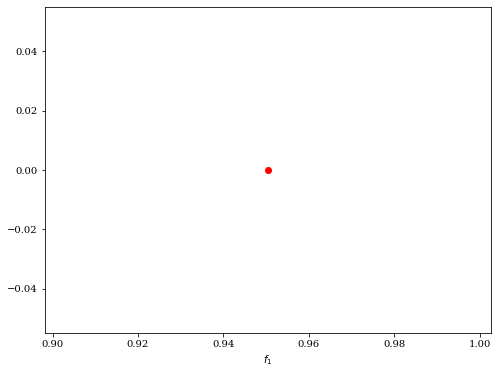

In [73]:
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
plot.show()

In [79]:
res.F

array([0.95049758])